<a href="https://colab.research.google.com/github/sayak395/Waveform_with_CNN/blob/Improvements/CNN_Assignment_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start of Project

<hr style="border:2px solid gray">

# Table of Contents <a id='index'></a>
1. [Exploring the Waveforms](#what)
2. [Designing the CNN](#design)
3. [Optimising the CNN depth](#conv depth)

<div style="background-color:#C2F5DD">

Before we start implementing a CNN it would be well worth the time to look at the waveforms more closely to identify features of importance, perhaps even Fourier Transform the data to get a feel. Then we can proceede to designing and training a neural network.

### Exploring the Waveforms <a id='what'></a>

<div style="background-color:#C2F5DD">

We can start off by straight away removing the first 200/250 points in all the waveforms because the recorded pulses begin at 250. This has a two-fold advantage:

1. This shortens the size of the dataset thus preventing any unncessary computation with the first few irrelevant points.

2. The removal of the first few points will prevent the CNN from attempting to learn features which are not relevant for the classification task.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #getting the files preloaded to avoid time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch
sns.set()

# choose your preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [ ]:
path = 'drive/MyDrive/Data/'

In [ ]:
# importing the datasets
xtrain = np.load(path+"x_train.npy")
ytrain = np.load(path+"y_train.npy")
xtest = np.load(path+"x_test.npy")
ytest = np.load(path+"y_test.npy")
print(xtrain.shape,xtest.shape)

(12302, 1000) (3076, 1000)


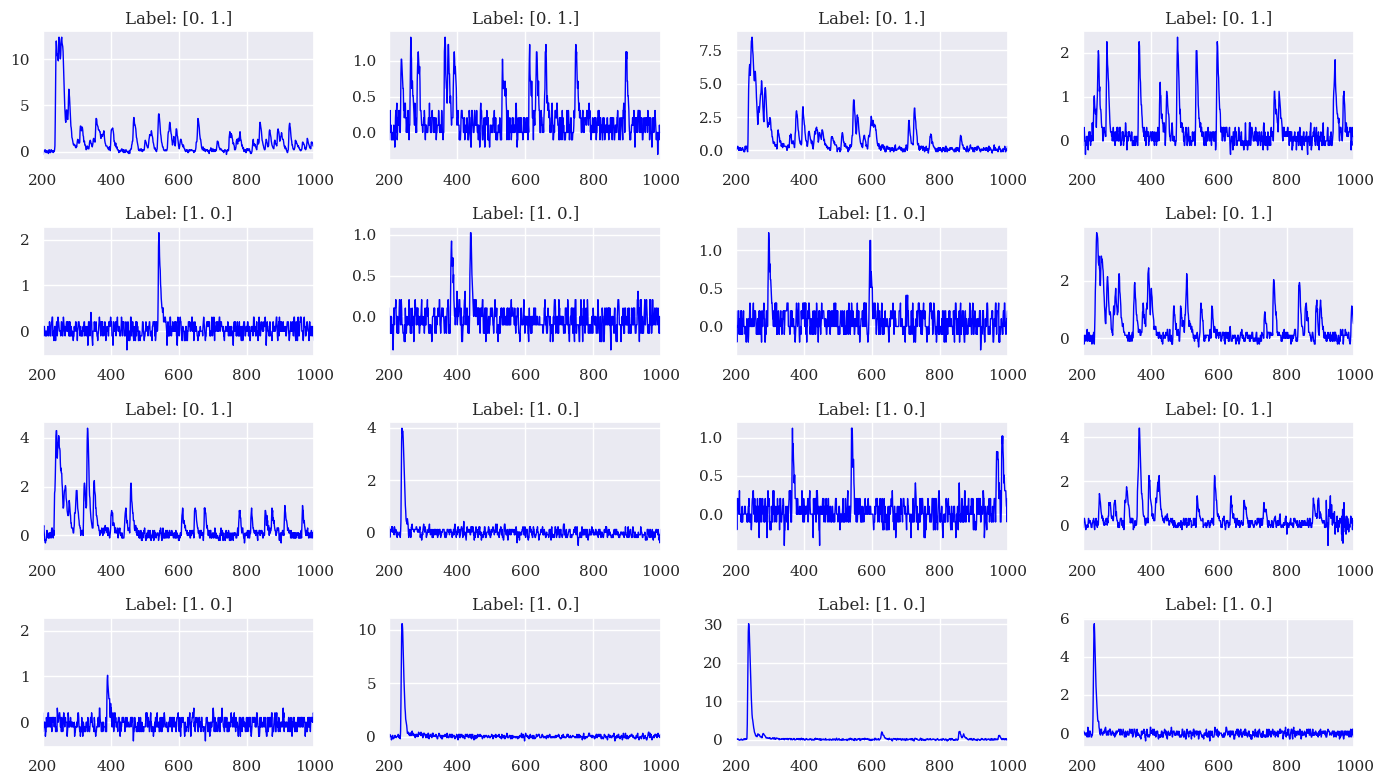

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain))
    #print(j)
    ax[i].plot(xtrain[j],color='blue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

### Designing the CNN <a id='design'></a>

<div style="background-color:#C2F5DD">

To begin designing the network we can layout a basic architecture whereby we design a relatively small network to get a feel of how it performs. Later on we can begin by optimising the parameters and experimenting with the network architecture.

In [ ]:
xtrain_torch = torch.tensor(xtrain).float() #transforming data to a tensor
ytrain_torch = torch.tensor(ytrain).float()
xtest_torch = torch.tensor(xtest).float()
ytest_torch = torch.tensor(ytest).float()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(xtrain_torch, ytrain_torch)
test_dataset = TensorDataset(xtest_torch, ytest_torch)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) #Loading data into a batch and use batch size of 64
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

<div style="background-color:#C2F5DD">

The following is a basic outline for the architecture of the CNN. So far, two convolutions have been added followed by some linear layers. A RELU activation function has been chosen because it returns non-zero gradients which is important for backpropagation and preventing dead neurons. However, at the end a sigmoid activation function has been used as this is a binary classification task and sigmoid returns either 0 or 1. The neurons at each layer and the pooling have been chosen arbitrarily and can be changed, but this is a good starting point to initially setup the network and see how good the CNN is at classifying the signal.

<div style="background-color:#C2F5DD">

Before we begin, a function has to be made to calculate the number of neurons outputted by the convolutional neural network layers to input into the linear layers.

In [ ]:
def getNeurons(input_neurons, kernel, filter, stride=1, padding=0, dilation=1):

  input = torch.tensor([input_neurons], dtype=torch.float32).to(device) #make torch tensor for gpu

  output_size = ((input + 2 * padding - dilation * (kernel - 1) - 1) / stride) + 1
  return output_size.int()

In [ ]:
#getNeurons(1000, kernel=5, filter=3) #check if function works

<div style="background-color:#C2F5DD">

The function used above was initially tried but due to error in computation another method was implemented whereby the shape was retrieved directly from a intial forward pass through the convolution layers. This had the disadvantage of computing the convultional layers twice but on a gpu it did not make a very drastic change.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 5)
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(64, 128, 5)

        #output_size = getNeurons(1000, self.conv1.kernel_size[0], self.conv1.stride[0], self.conv1.padding[0], self.conv1.dilation[0])
        #output_size = getNeurons(output_size, self.pool.kernel_size, self.pool.stride, self.pool.padding, self.pool.dilation)
        #output_size = getNeurons(output_size, self.conv2.kernel_size[0], self.conv2.stride[0], self.conv2.padding[0], self.conv2.dilation[0])
        #output_size = getNeurons(output_size, self.pool.kernel_size, self.pool.stride, self.pool.padding, self.pool.dilation)
        #print(output_size)

        x = torch.randn(1, 1, 1000)
        output_shape = self.dummy_forward(x).size(-1)

        self.fc1 = nn.Linear(128 * output_shape, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(10, 1)

    def dummy_forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #check GPU acceleration
net = Net().to(device) #initialise the network
print(f'Device being used is: {device}')

Device being used is: cpu


<div style="background-color:#C2F5DD">

The loss function used here was the Binary Cross Entropy loss, which is the most commonly used one for binary classification problems which measures the loss between the target and the input probabilities. This loss function was preferred over Cross Entropy Loss which is more popular for multi-class classification problems. Again, the parameters of the SGD algorithm can be adjusted later on but for now some arbitrary but sensible values have been chosen.

In [ ]:
import torch.optim as optim

def train(model, max_epoch=10, momentum=0.9, lr=0.01, train_loader=train_loader):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    model.train()  # Set model to training mode
    model.to(device)

    epoch_loss = []
    epoch_acc = []

    for epoch in range(max_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for data in train_loader:
            inputs, labels = data
            inputs = inputs.unsqueeze(1)  # add channel column
            labels = labels[:, 0].unsqueeze(1)  # only use one column

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.where(outputs > 0.5, torch.tensor(1.0, device=device), torch.tensor(0.0, device=device))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss.append(running_loss / len(train_loader))
        epoch_acc.append(100 * correct / total)

    return epoch_loss, epoch_acc




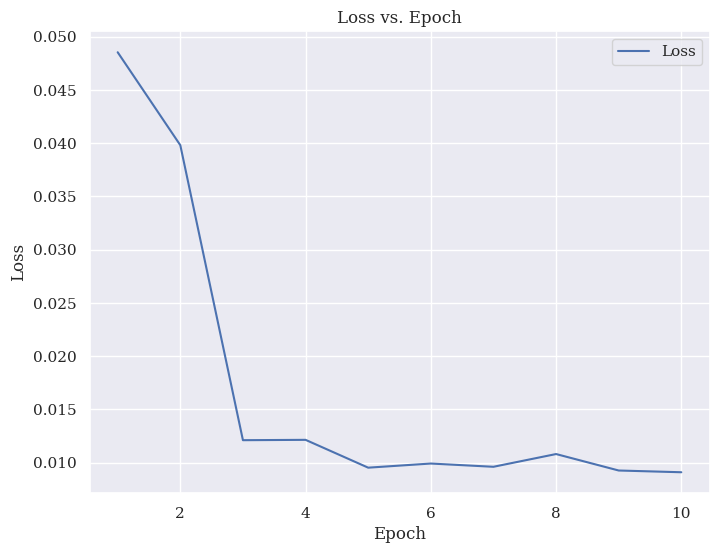

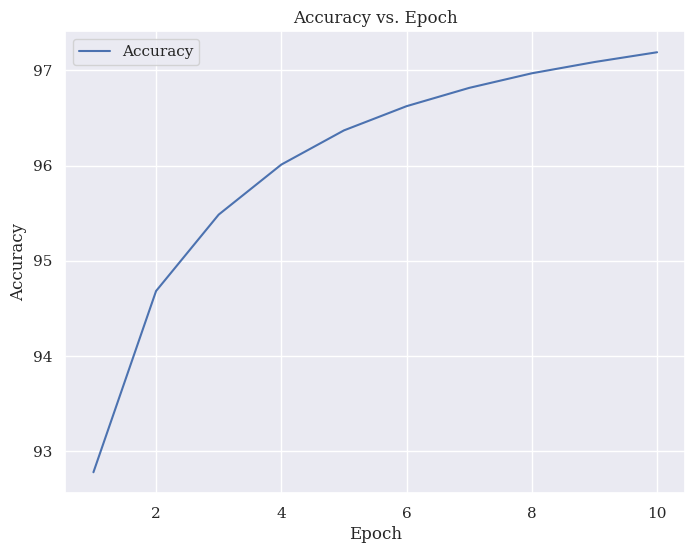

Finished Training


In [ ]:
tl, ta = train(model=net)

# <div style="background-color:#C2F5DD">

Now that a basic CNN has been trained, it would be instructive to examine how this CNN performs on the entire dataset.

In [ ]:
def test(model, test_loader=test_loader):
    criterion = nn.BCELoss()
    model.eval()
    model.to(device)

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            labels = labels[:, 0].unsqueeze(1)

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = torch.where(outputs > 0.5, torch.tensor(1.0, device=device), torch.tensor(0.0, device=device))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(test_loader), 100 * correct / total


In [ ]:
l, a = test(model=net)

The accuracy is 98.05 %


([0.05699709076434374], [98.04941482444734])

Below we have defined a function to plot the training against the testing loss. The training loss will be important to identify whether the model generalises well whilst the validation loss will verify if the model is the overfitting or underfitting.

In [ ]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc, title='Training vs. Validation Metrics'):
    """
    Plots the training and validation loss and accuracy.

    Args:
    train_loss (list): List of training losses.
    val_loss (list): List of validation losses.
    train_acc (list): List of training accuracies.
    val_acc (list): List of validation accuracies.
    title (str): Title of the plot.
    """
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plotting training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
plot_metrics(tl, l, ta, a)

<div style="background-color:#C2F5DD">

The accuracy is good but of course the architecture of the neural network can be improved massively. Firstly, we can experiment with number of neurons in each layer and the depth of the network. We can try and optimise the SGD algorithm parameters and the number of passes through the data. Initially, lets begin by attempting to adjust the CNN by changing the convultion layers, the size of the kernel and the adjusting the neurons and depth in the linear layers. However, caution has to be maintained with dead neurons which have a gradient close to 0 so they don't train well.

Now let us begin by improving the architecture of the network such as the number of neurons, the layers, the kernel sizes etc. To simplify the optimisation we can attempt to optimise the linear and convolutional part separately. This is an acceptable approach because the purpose of the convolutional section is to identify features in the waveform and process the image data. The actual classification is done by the linear section so it okay to optimise the two parts seperately as they are serving a different purpose.

In [ ]:
class Net_improved(nn.Module):
    def __init__(self, num_convolutional_layers=4, kernel_size=2, padding=0,
                 stride=1, dilation=1, pool_size=2):
        super().__init__()

        self.kernel_size = kernel_size

        self.conv_layers = [] #store layers


        in_channels = 1 #initial input of waveform
        out_channels = 64


        for layer_idx in range(num_convolutional_layers):

          self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size,
                                    stride, padding, dilation))
          self.conv_layers.append(nn.ReLU())
          self.conv_layers.append(nn.MaxPool1d(pool_size)) # Using a fixed pool size for simplicity

          in_channels = out_channels
          out_channels = out_channels * 2  # Double the output channels for the next layer


        self.conv_layers = nn.Sequential(*self.conv_layers)

        x = torch.randn(1, 1, 1000)
        output_shape = self.dummy_forward(x).size(-1)

        self.linear_layers = nn.Sequential( #manually adding linear layers

        nn.Linear(output_shape, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
        nn.Sigmoid()
        )

        self.linear_layers = nn.Sequential(*self.linear_layers)

    def dummy_forward(self, x): #calculating shape after convolution
      with torch.no_grad():
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        return x


    def forward(self, x):
      x = self.conv_layers(x)
      x = torch.flatten(x, 1)
      x = self.linear_layers(x)
      return x




In [ ]:
new_net = Net_improved() #trial to see if code works

In [ ]:
print(new_net) #check if model has been created properly

Net_improved(
  (conv_layers): Sequential(
    (0): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(2,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(256, 512, kernel_size=(2,), stride=(1,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=31232, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


#### Optimising convolution network depth <a id='conv depth'></a>

In [ ]:
from tqdm import tqdm

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
depth = []

for i in tqdm(range(8), desc='Optimising depth...'): #investigate depth of network

  new_net = Net_improved(num_convolutional_layers=int(i))

  train_loss, train_acc = train(model=new_net)
  epoch_loss, epoch_acc = test(model=new_net)
  train_loss.append(train_loss)
  train_accuracy.append(train_acc)
  test_loss.append(epoch_loss)
  test_accuracy.append(epoch_acc)
  depth.append(i + 1)

best_depth = np.argmax(total_accuracy) + 1
plt.title('Variation of accuracy with depth')
plt.xlabel('Convolution Layer Depth')
plt.ylabel('Accuracy Score')
plt.plot(depth, total_accuracy, label='accuracy')
plt.show()


print(f'The best depth is {best_depth}')

Optimising depth...:  12%|█▎        | 1/8 [00:02<00:14,  2.04s/it]

Finished Training
The accuracy is 97.04 %
Finished Training


Optimising depth...:  25%|██▌       | 2/8 [00:54<03:09, 31.62s/it]

The accuracy is 97.76 %
Finished Training


Optimising depth...:  38%|███▊      | 3/8 [02:39<05:25, 65.03s/it]

The accuracy is 98.08 %
Finished Training


Optimising depth...:  50%|█████     | 4/8 [05:31<07:09, 107.41s/it]

The accuracy is 98.31 %
Finished Training


Optimising depth...:  62%|██████▎   | 5/8 [10:17<08:35, 171.84s/it]

The accuracy is 98.50 %
Finished Training


Optimising depth...:  75%|███████▌  | 6/8 [18:36<09:26, 283.02s/it]

The accuracy is 98.11 %


In [ ]:
plot_metrics(train_loss, test_loss, train_accuracy, test_accuracy) #check the metrics to ensure model is performing well

<div style="background-color:#C2F5DD">

After the optimisation has been run we can see that the optimal depth is 5 for the convolution layers. This physically makes sense because the input waveform is not a complicated image input thus too many layers should not be required to detect the features in the waveform image. However, for the architecture of the model, a depth of 2 was chosen to reduce the complexity of the model and using 5/6 layers only increases the accuracy by 0.1%. Using less layers also reduces the complexity of the network so the risk of overfitting is reduced.

Now the layers have been chosen, the kernel size, padding, dilation can be experimented with.

In [ ]:
min_matrix = np.zeros((2, 2, 4, 2))

for i in tqdm(range(2), desc='Minimising'): #optimising parameters
  for j in range(2):
    for k in range(4):
      for l in range(2):
        new_net = Net_improved(num_convolutional_layers=2, kernel_size=k+1, padding=i, dilation=j+1, pool_size=l+1)
        _, _ = train(model=new_net, plot = False)
        epoch_loss, epoch_acc = test(model=new_net)
        min_matrix[i, j, k, l] = epoch_acc[0]

In [ ]:
min_index = np.argmin(min_matrix)
min_indices = np.unravel_index(min_index, min_matrix.shape)
print("Indices of minimum value:", min_indices)

In [ ]:
best_padding = min_indices[0]
best_dilation = min_indices[1] + 1
best_kernel_size = min_indices[2] + 1
best_pool_size = min_indices[3] + 1

In [ ]:
improved_net = Net_improved(num_convolutional_layers=2, kernel_size=min_indices[2]+1,
                            padding=min_indices[0], dilation=min_indices[1]+1,
                            pool_size=min_indices[3]+1) #testing whether the optimisation made a difference

In [ ]:
_ = train(model=improved_net, max_epoch=50) #running for longer epochs to really examine neural network

In [ ]:
test(model = improved_net)

<div style="background-color:#C2F5DD">

We can see now the model running for a longer time of 50 epochs. The training parameters can be optmised later such as the batch size or the learning rate/momentum for the SGD algorithm. The model seems to be perform well. The kernel size, pool size do not need to be adjusted exactly because they are only providing incremental changes to the accuracy, a rough consideration is good enough.

For parameters such as stride, pool size we would expect these parameters to be close to 0 or very small because the convolution layer is relatively shallow thus the number of channels should not get out of hand rapidly. The stride parameter was not used for this reason and implementing a stride usually results in a loss of feature information. Thus, given the shallow nature of the network, the stride parameter was ignored.

Now we can adjust the channels in the convolution layers.

In [ ]:
class better_CNN_net(nn.Module):

  def __init__(self, in_channel=64, out_channel=128, act_fn=nn.ReLU(),
               kernel_size = best_kernel_size, pool_size=best_pool_size,
               padding=best_padding, dilation=best_dilation):

    super().__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv1d(1, in_channel, kernel_size=kernel_size,
                  padding=padding, dilation=dilation),
        act_fn,
        nn.MaxPool1d(pool_size),
        nn.Conv1d(in_channel, out_channel, kernel_size=kernel_size,
                  padding=padding, dilation=dilation),
        act_fn,
        nn.MaxPool1d(pool_size)
    )

    self.conv_layers = nn.Sequential(*self.conv_layers)

    x = torch.randn(1, 1, 1000)
    output_shape = self.dummy_forward(x).size(-1)

    self.linear_layers = nn.Sequential(
        nn.Linear(output_shape, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
        nn.Sigmoid()
    )

    self.linear_layers = nn.Sequential(*self.linear_layers)

  def dummy_forward(self, x):
      with torch.no_grad():
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        return x

  def forward(self, x):
      x = self.conv_layers(x)
      x = torch.flatten(x, 1)
      x = self.linear_layers(x)
      return x

In [ ]:
channel_list = [16,32,64,128,256,512,1024] #sample channels to search

min_matrix = np.zeros((len(channel_list), len(channel_list)))

for idx, channel in enumerate(channel_list):
  for idx2, channel2 in enumerate(channel_list):

    if idx == idx2: #ignore same connections between layers
      continue

    better_net = better_CNN_net(in_channel=channel, out_channel=channel2)
    _, _ = train(model=better_net, plot = False)
    epoch_loss, epoch_acc = test(model=better_net)
    min_matrix[idx, idx2] = epoch_acc[0]


In [ ]:

max_value = np.max(min_matrix)  # Find the maximum value in the matrix
max_index = np.unravel_index(np.argmax(min_matrix), min_matrix.shape)

best_in_channel = channel_list[max_index[0]]
best_out_channel = channel_list[max_index[1]]

print("Maximum accuracy is achieved with an input channel size of", best_in_channel,
      "and output channel size of", best_out_channel)
print(f"Maximum accuracy: {max_value:.2f}%")

<div style="background-color:#C2F5DD">

Finally the convolutional part has been fully optimised we can now turn our attention the the linear layers. The linear layers will have some additional consideration such as dead neurons. Care has to be taken to make sure too many neurons are not dead. This is where a droput layer can also be introduced which will deactivate some neurons on purpose which in turn will prevent overfitting during training.

We can check with our convolution to see how many dead neurons there are and also introduce some dropout layers to prevent overfitting. Finally, we can experiment using leakyReLU as an activation function which has a slight non-zero gradient for the negatives which prevents gradients being too close to 0.

In [ ]:
test_net = better_CNN_net(in_channel=best_in_channel, out_channel=best_out_channel,
                          kernel_size=best_kernel_size, pool_size=best_pool_size,
                          padding = best_padding, dilation=best_dilation)
test_net.to(device)

In [ ]:

# class better_CNN_net(nn.Module): #redefine with all the optimal parameters
#     def __init__(self, in_channel, out_channel, act_fn=nn.ReLU(),
#                  kernel_size=1, pool_size=3, padding=0, dilation=1,
#                  initial_features=128, depth=3, dropout_rate=0.5):
#         super().__init__()

#         # Define the convolutional layers
#         self.conv_layers = nn.Sequential(
#             nn.Conv1d(1, in_channel, kernel_size=kernel_size, padding=padding, dilation=dilation),
#             act_fn,
#             nn.MaxPool1d(pool_size),
#             nn.Conv1d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, dilation=dilation),
#             act_fn,
#             nn.MaxPool1d(pool_size)
#         )

#         # Dummy input to determine the output size from the convolutional stack
#         x = torch.randn(1, 1, 1000)
#         output_shape = self.dummy_forward(x).size(-1)

#         # Initialize the list of linear layers
#         linear_layers = []
#         input_features = output_shape

#         # Add additional layers with doubling the features each time
#         for _ in range(depth):
#             output_features = input_features * 2  # Double the number of features from the previous layer
#             linear_layers.append(nn.Linear(input_features, output_features))
#             linear_layers.append(act_fn)
#             if dropout_rate > 0:
#                 linear_layers.append(nn.Dropout(dropout_rate))
#             input_features = output_features

#         # Add the final output layer
#         linear_layers.append(nn.Linear(input_features, 1))
#         linear_layers.append(nn.Sigmoid())

#         self.linear_layers = nn.Sequential(*linear_layers)

#     def dummy_forward(self, x):
#         with torch.no_grad():
#             x = self.conv_layers(x)
#             x = torch.flatten(x, 1)
#             return x

#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = torch.flatten(x, 1)
#         x = self.linear_layers(x)
#         return x


### Optimisng the Linear Network

In [ ]:
total_accuracy = []
depth = []

for i in tqdm(range(8), desc='Optimising depth...'): #investigate depth of network

  new_net = better_CNN_net(
    in_channel=best_in_channel,
    out_channel=best_out_channel,
    kernel_size=best_kernel_size,
    pool_size=best_pool_size,
    padding=best_padding,
    dilation=best_dilation,
    depth=i,
    dropout_rate=-1)

  _, _ = train(model=new_net, plot = False)
  epoch_loss, epoch_acc = test(model=new_net)
  total_loss.append(epoch_loss)
  total_accuracy.append(epoch_acc)
  depth.append(i + 1)

best_depth = np.argmax(total_accuracy) + 1
plt.title('Variation of accuracy with depth')
plt.xlabel('Convolution Layer Depth')
plt.ylabel('Accuracy Score')
plt.plot(depth, total_accuracy, label='accuracy')
plt.show()


print(f'The best depth is {best_depth}')



<div style="background-color:#C2F5DD">

The linear layer depth does not seem to change the accuracy too drastically which probably indicates that the network arhcitecture is close to the optimal setting. Thus choosing a depth of 2 for the linear layers to simplify the model preventing the risk of overfitting associated with a deeper model whilst also reducing the computational cost associated with a larger network. A depth of 2 was chosen over 1 because that would allow no hidden layers to be chosen, in turn increasing the risk of underfitting the data.

At this point we can experiment with different loss functions such as leaky ReLU and droputs between layers to improve regualrisation during training and prevent overfitting.

In [ ]:
class final_CNN(nn.Module):
    def __init__(self, in_channel=best_in_channel, out_channel=best_out_channel,
                 act_fn=nn.ReLU(),
                 kernel_size=best_kernel_size,
                 pool_size=best_pool_size, padding=best_padding, dilation=best_dilation,
                 neurons = 128, dropout_rate=0.2):
        super().__init__()

        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, in_channel, kernel_size=kernel_size, padding=padding, dilation=dilation),
            act_fn,
            nn.MaxPool1d(pool_size),
            nn.Conv1d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, dilation=dilation),
            act_fn,
            nn.MaxPool1d(pool_size)
        )

        # Dummy input to determine the output size from the convolutional stack
        x = torch.randn(1, 1, 1000)
        output_shape = self.dummy_forward(x).size(-1)

        self.linear_layers = nn.Sequential(
            nn.Linear(output_shape, neurons),
            act_fn,
            nn.Dropout(dropout_rate),
            nn.Linear(neurons, 1),
            nn.Sigmoid(),
        )


        self.linear_layers = nn.Sequential(*linear_layers)

    def dummy_forward(self, x):
        with torch.no_grad():
            x = self.conv_layers(x)
            x = torch.flatten(x, 1)
            return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.linear_layers(x)
        return x


Finally, the number of neurons can be optimised. To identify if the droputs/ leaky ReLU functions make a different or not we need to examine the training loss and see which one gives a smoother learning curve. This would be indicative of the model training well and generalising to the data.

In [ ]:
best_neurons = 0
best_acc = 0

for neuron in channel_list:
  better_net = final_CNN(neurons=neuron)
  _, _ = train(model=better_net, plot = False)
  epoch_loss, epoch_acc = test(model=better_net)
  if epoch_acc[0] > best_acc:
    best_acc = epoch_acc[0]
    best_neurons = neuron

print(f'The optimal number of neurons is {best_neurons}')

In [ ]:
better_net = final_CNN(neurons=best_neurons, act_fn=nn.LeakyReLU()) #checking with leaky ReLU
train_loss, train_acc = train(model=better_net, plot = False)
test_loss, test_acc = test(model=better_net) #observe the accuracy
plot_metrics(train_loss, test_loss, train_acc, test_acc)

The last thing remaining is to optimise the learning parameters for the stochastic gradient desecent. This will ensure that the optimal parameters are found via SGD algorithm.

In [ ]:
import numpy as np

# Define ranges for the learning rate and momentum
learning_rates = [0.001, 0.01, 0.1]
momentums = [0.5, 0.9, 0.99]

# Storage for results
results = {}

for lr in learning_rates:
    for momentum in momentums:
        train_loss, train_acc = train(model, train_loader, device, max_epoch=10, momentum=momentum, lr=lr)
        val_loss, val_acc = test(model, test_loader, device)
        results[(lr, momentum)] = (train_loss, val_loss, train_acc, val_acc)
        print(f"LR: {lr}, Momentum: {momentum}, Val Acc: {val_acc}, Val Loss: {val_loss}")

# Find the best hyperparameters
best_params = max(results, key=lambda x: results[x][3])  # Based on validation accuracy
best_train_loss, best_val_loss, best_train_acc, best_val_acc = results[best_params]

print(f"Best Learning Rate: {best_params[0]}, Best Momentum: {best_params[1]}")
print(f"Validation Accuracy: {best_val_acc}, Validation Loss: {best_val_loss}")

# Plot the results for the best hyperparameters
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), best_train_loss, label='Training Loss')
plt.plot(range(1, 11), best_val_loss, label='Validation Loss')
plt.title('Best Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), best_train_acc, label='Training Accuracy')
plt.plot(range(1, 11), best_val_acc, label='Validation Accuracy')
plt.title('Best Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare data
learning_rates = [0.001, 0.01, 0.1]
momentums = [0.5, 0.9, 0.99]

# Prepare mesh grid
X, Y = np.meshgrid(learning_rates, momentums)
Z = np.array([[results[(lr, mo)][3] for lr in learning_rates] for mo in momentums])

# Plotting
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Momentum')
ax.set_zlabel('Validation Accuracy')

ax.set_title('3D plot of Accuracy vs. Learning Rate and Momentum')

plt.show()
